In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

import numpy as np
import pandas as pd
import xarray as xr

pd.set_option('precision', 2)
np.set_printoptions(precision=2, suppress=True, nanstr='nan', 
                    infstr='inf', threshold=5)

# Preface / Setup

Pre-load some of the USHCN daily data that we downloaded, so that we can use it in examples. We'll load in the TMAX, TMIN, PRCP data, as well as the station metadata.

If you want to follow along with the presenation, you probably want to skip to the section "What is pandas?"

In [3]:
def load_data(field):
    print("Loading " + field)
    df = (pd.read_pickle("data/ushcn2014_raw_{}.p".format(field))
            .set_index(['COOP_ID', 'date'])
            .sortlevel()
            .drop(['STATION', 'DM', 'QC', 'DS', 'YEAR', 'month'], axis=1))
    return df

tmax = load_data('tmax')
tmin = load_data('tmin')
prcp = load_data('prcp')
stations = pd.read_pickle("data/ushcn-stations.p")

Loading tmax
Loading tmin
Loading prcp


Merge the data together into a master, "long-form" dataset. Note that each **Series** is about 1.5 million entries long, and we'll concatenate along the common **Index** (really CCOP_ID-date **MultiIndex**). That's a *slightly* expensive operation, since we have to align all the data. It takes about 20 seconds on my 2010-era MacBook Pro with a 2.66 GHz Core I7 processor.

In [8]:
ushcn_data = pd.concat([tmax, tmin, prcp], axis=1)

Additionally, merge the *tmax* data with the station data for some simple aggregation analysis later.

In [5]:
tmax_merged = (
    tmax.reset_index()
        .join(stations, on='COOP_ID')
        .set_index(['COOP_ID', 'date'])
)
tmax_merged.head()

tmax    LAT    LON  ELEV STATE           NAME   COMP1  \
COOP_ID date                                                                
11084   1891-01-01   NaN  31.06 -87.05  25.9    AL  BREWTON 3 SSE  ------   
        1891-02-01   NaN  31.06 -87.05  25.9    AL  BREWTON 3 SSE  ------   
        1891-03-01   NaN  31.06 -87.05  25.9    AL  BREWTON 3 SSE  ------   
        1891-04-01   NaN  31.06 -87.05  25.9    AL  BREWTON 3 SSE  ------   
        1891-05-01   NaN  31.06 -87.05  25.9    AL  BREWTON 3 SSE  ------   

                     COMP2   COMP3  dUTC  
COOP_ID date                              
11084   1891-01-01  ------  ------     6  
        1891-02-01  ------  ------     6  
        1891-03-01  ------  ------     6  
        1891-04-01  ------  ------     6  
        1891-05-01  ------  ------     6

## Seattle

Select some data from Seattle

In [9]:
seattle_id = 457458
print(stations.loc[seattle_id])

LAT                      48
LON                -1.2e+02
ELEV                    5.8
STATE                    WA
NAME     SEATTLE URBAN SITE
COMP1                457478
COMP2                ------
COMP3                ------
dUTC                      8
Name: 457458, dtype: object


In [10]:
seattle_ushcn = ushcn_data.loc[seattle_id]
seattle_ushcn.head()

,tmax,tmin,prcp
date,,,
1894-01-01,427.0,348.0,601.0
1894-02-01,428.0,335.0,421.0
1894-03-01,491.0,362.0,626.0
1894-04-01,549.0,410.0,422.0
1894-05-01,607.0,461.0,200.0


Compute monthly mean anomalies and plot.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10f7766a0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11636c2b0>], dtype=object)

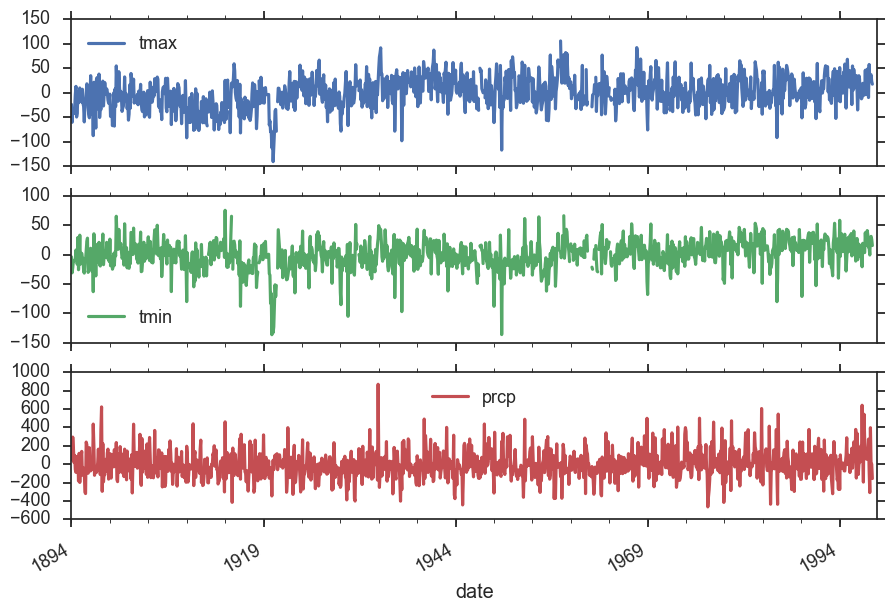

In [11]:
def _anom(x):
    return x - x.mean()

(seattle_ushcn
     .groupby(lambda x: x.month)
     .apply(_anom)
     .plot(subplots=True))

Pandas vs Matplotlib plotting interface

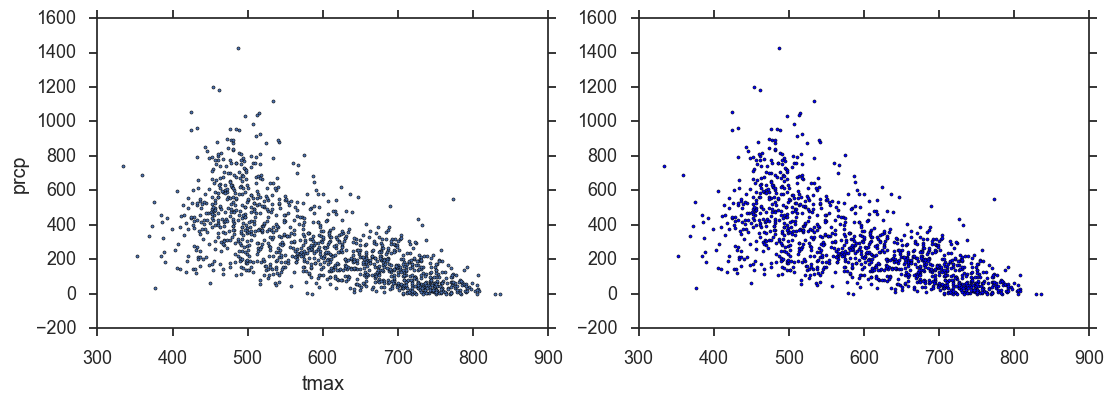

In [12]:
nrows, ncols = 1, 2
size, aspect = 4., 16./10.
width, height = size*ncols*aspect, size*nrows

fig, axs = plt.subplots(nrows, ncols, figsize=(width, height))
ax1, ax2 = axs

style = dict(marker='.')

# Plot using pandas
seattle_ushcn.plot(x='tmax', y='prcp', kind='scatter', ax=ax1, **style)

# Plot using matplotlib
ax2.scatter('tmax', 'prcp', data=seattle_ushcn, **style)

// Styling
<style type="text/css">
.input_prompt, .input_area, .output_prompt {
display:none !important;
}
.reveal h1, .reveal h2 {
    font-family:"League Gothic"
}
</style>

# <center> Basic Pandas </center>

<br>

<center>
    <b>Daniel Rothenberg</b> | darothen@mit.edu
    <p>Seventh Symposium on Advances in Modeling and Analysis Using Python</p>
    <p>AMS Annual Meeting, Seattle, WA</p>
    <p>January 24, 2017</p>
</center>

---

<img src="figs/pandas_logo.png">

## What is [pandas](http://pandas.pydata.org)?

- Toolkit built on-top of NumPy to emulate R's `data.frame`
- Performance-focused
- Simple API with rich documentation
- Developed by quantitative finance folks ([@wesmckinn](http://www.twitter.com/wesmckinn))


### ... and why should I care?

- Make data processing and cleaning easy! 
- Make data analysis fast and fun!
- Open your data workflows to powerful new tools

### Use the right tool for your job!

<img src="figs/wrong_tool.jpg">

### How to follow along

1. Download [this notebook and utilities from github](https://github.com/darothen/python_for_climate_data_science) (**bit.ly/2iSCY0c**), and run the code samples as we go or follow in your browser.

2. Open an `ipython` interpreter and enter the code by hand.

<br>

``` shell
$ ipython
Python 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12)
Type "copyright", "credits" or "license" for more information.

IPython 5.1.0 -- An enhanced Interactive Python.
?         -> Introduction and overview of IPython's features.
%quickref -> Quick reference.
help      -> Python's own help system.
object?   -> Details about 'object', use 'object??' for extra details.

In [1]: <your code here>
```

## Basics and Overview

## [Series](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#series)

<blockquote>
    <b>A one-dimensional, labeled array capable of holding any data type.</b>
</blockquote>

<img src="figs/series.svg" style="width: 400px">

### Creating Series

From list-like data...

In [13]:
temperature_data = [21, 25, 16, 22, 16, 21, 15]
pd.Series(temperature_data)

0    21
1    25
2    16
3    22
4    16
5    21
6    15
dtype: int64

With custom index...

In [14]:
days_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                    'Friday', 'Saturday', 'Sunday']
temperature_series = pd.Series(temperature_data, index=days_of_the_week)
temperature_series.head()

Monday       21
Tuesday      25
Wednesday    16
Thursday     22
Friday       16
dtype: int64

### Labeled Indexing

How would we find the temperature for Thursday?

In [15]:
for idx, val in enumerate(days_of_the_week):
    if val == "Thursday": break

idx, temperature_data[idx]

(3, 22)

... but what if we have labeled data?

In [16]:
temperature_series['Thursday']

22

### "Fancy" Indexing

Any boolean vector with the same shape as your `Index` can be used to select data.

In [17]:
temperature_series < 20

Monday       False
Tuesday      False
Wednesday     True
Thursday     False
Friday        True
Saturday     False
Sunday        True
dtype: bool

In [18]:
temperature_series[temperature_series < 20]

Wednesday    16
Friday       16
Sunday       15
dtype: int64

### Applying Functions

In [19]:
def f_to_c(temp_f):
    """ Convert temperature from degrees F to degrees C """
    temp_c = (5./9.) * (temp_f - 32)
    return temp_c

In [20]:
print("{deg_f}F = {deg_c}C".format(deg_f=32.0, deg_c=f_to_c(32)))

32.0F = 0.0C


In [21]:
f_to_c(temperature_series)

Monday      -6.11
Tuesday     -3.89
Wednesday   -8.89
Thursday    -5.56
Friday      -8.89
Saturday    -6.11
Sunday      -9.44
dtype: float64

Automatic vectorization, like wrapping with `@numpy.vectorize`. 

### Applying Functions (cont'd)

In [22]:
np.mean(temperature_series)

19.428571428571427

In [23]:
(temperature_series.min(),
 temperature_series.quantile(0.33),
 temperature_series.mean(), 
 temperature_series.median(),
 temperature_series.quantile(0.66),
 temperature_series.max())

(15, 16.0, 19.428571428571427, 21.0, 21.0, 25)

## [DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe)


<blockquote>
    <b>A two-dimensional, labeled data structure organized into rows and columns of potentially heterogeneous type</b>
</blockquote>


<img src="figs/dataframe.svg" style="width: 800px">

### Creating DataFrames

Constructing dictionaries of data is often the easiest way to create DataFrames

In [24]:
data = {
    'high_temp': [21, 35, 32, 40, 20],
    'low_temp': [14, 20, 29, 25, -1],
    'station': ['KEYW', 'KMDT', 'KGRI', 'KRNO', 'KTVC']
}
pd.DataFrame(data)

,high_temp,low_temp,station
0,21,14,KEYW
1,35,20,KMDT
2,32,29,KGRI
3,40,25,KRNO
4,20,-1,KTVC


In [25]:
pd.DataFrame(data, index=['Week {}'.format(i) for i in range(1, 6)])

,high_temp,low_temp,station
Week 1,21,14,KEYW
Week 2,35,20,KMDT
Week 3,32,29,KGRI
Week 4,40,25,KRNO
Week 5,20,-1,KTVC


**Nested dictionaries**

In [26]:
nest_data = {
   'high_temp': { 'Week 1': 21, 'Week 2': 35, 'Week 3': 32 },
   'low_temp': { 'Week 2': 20, 'Week 4': 25, 'Week 5': -1 },
   'station': { 'Week 1': 'KEYW', 'Week 3': 'KGRI', 'Week 4': 'KRNO'},
}
pd.DataFrame(nest_data)

,high_temp,low_temp,station
Week 1,21.0,NaN,KEYW
Week 2,35.0,20.0,NaN
Week 3,32.0,NaN,KGRI
Week 4,NaN,25.0,KRNO
Week 5,NaN,-1.0,NaN


**2D arrays**

In [27]:
mat = np.random.randint(-10, 20, size=(5, 3))
pd.DataFrame(mat, columns=['x', 'y', 'vel'], 
             index=pd.Index([1, 2, 3, 4, 5], name='sample'))

,x,y,vel
sample,,,
1,13,-5,5
2,-5,7,13
3,8,3,15
4,12,12,-6
5,14,17,12


**Structured / Record Arrays**

In [28]:
dt = [
    ('x', '<f8'), 
    ('y', '<f8'), 
    ('vel', '<f8')
]
mat_rec = np.rec.fromarrays(mat.T.tolist(), dtype=dt)
mat_rec['x'], mat_rec['y']

(array([ 13.,  -5.,   8.,  12.,  14.]), array([ -5.,   7.,   3.,  12.,  17.]))

In [29]:
pd.DataFrame(mat_rec, index=pd.Index(range(1, 6), name='sample_id'))

,x,y,vel
sample_id,,,
1,13.0,-5.0,5.0
2,-5.0,7.0,13.0
3,8.0,3.0,15.0
4,12.0,12.0,-6.0
5,14.0,17.0,12.0


In [30]:
df = pd.DataFrame(mat_rec, index=pd.Index(range(1, 6), name='sample_id'))

### DataFrame Structure

<center><img src="figs/dataframe.svg" style="width: 700px"></center>

In [31]:
df.index

RangeIndex(start=1, stop=6, step=1, name='sample_id')

In [32]:
df.columns

Index(['x', 'y', 'vel'], dtype='object')

In [33]:
df.values

array([[ 13.,  -5.,   5.],
       [ -5.,   7.,  13.],
       [  8.,   3.,  15.],
       [ 12.,  12.,  -6.],
       [ 14.,  17.,  12.]])

### DataFrame Structure

In [34]:
df.T

sample_id,1,2,3,4,5
x,13.0,-5.0,8.0,12.0,14.0
y,-5.0,7.0,3.0,12.0,17.0
vel,5.0,13.0,15.0,-6.0,12.0


In [35]:
df['x']

sample_id
1    13.0
2    -5.0
3     8.0
4    12.0
5    14.0
Name: x, dtype: float64

In [36]:
df.x

sample_id
1    13.0
2    -5.0
3     8.0
4    12.0
5    14.0
Name: x, dtype: float64

In [37]:
df.ix[1]

x      13.0
y      -5.0
vel     5.0
Name: 1, dtype: float64

### Ingesting DataFrames from Disk

Go-to methods: **read_csv()**, **read_table()**, and **read_fmf()**

-   **filepath_or_buffer**: a path to a filename, or some other object
    with a `read()` method.
-   **sep**: delimiter separating values in your data. By default, this
    will be ',' for `read_csv()` and '\t' for `read_table()`, although
    you can pass it any regular expression. If you don't pass one,
    pandas will try to infer it automatically.
-   **delim_whitespace**: should pandas include arbitrary whitespace as a
    delimiter?
-   **header**: row numbers to use as column names, and where the data
    starts in the file
-   **names**: a list of column names to use; if the data has no header,
    this should be used with `header=None`
-   **index_col**: column to use as row labels
-   **skip{rows,footer}**: skip beginning/ending rows.


### Example: GISTEMP Global Monthly Mean Anomalies

In [38]:
!head -n 4 data/GLB.Ts+dSST.csv

Land-Ocean: Global Means
Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
1880,-.30,-.21,-.18,-.27,-.14,-.29,-.24,-.07,-.17,-.16,-.19,-.22,-.20,***,***,-.20,-.20,-.17
1881,-.10,-.14,.01,-.03,-.04,-.29,-.07,-.03,-.09,-.20,-.26,-.16,-.12,-.12,-.15,-.02,-.13,-.18


In [39]:
df = pd.read_csv("data/GLB.Ts+dSST.csv", 
                 skiprows=1, header=0, index_col=0, na_values='***')
df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
Year,,,,,,,,,,,,,,,,,,
1880,-0.30,-0.21,-0.18,-0.27,-0.14,-0.29,-0.24,-0.07,-0.17,-0.16,-0.19,-0.22,-0.20,NaN,NaN,-0.20,-0.20,-0.17
1881,-0.10,-0.14,0.01,-0.03,-0.04,-0.29,-0.07,-0.03,-0.09,-0.20,-0.26,-0.16,-0.12,-0.12,-0.15,-0.02,-0.13,-0.18
1882,0.09,0.08,0.01,-0.20,-0.18,-0.25,-0.11,0.03,-0.01,-0.22,-0.21,-0.25,-0.10,-0.09,0.00,-0.12,-0.11,-0.15
1883,-0.34,-0.42,-0.18,-0.24,-0.25,-0.12,-0.08,-0.13,-0.18,-0.11,-0.20,-0.18,-0.20,-0.21,-0.34,-0.22,-0.11,-0.17
1884,-0.18,-0.12,-0.34,-0.36,-0.32,-0.38,-0.34,-0.26,-0.23,-0.22,-0.29,-0.29,-0.28,-0.27,-0.16,-0.34,-0.32,-0.25


### Example: GISTEMP Global Monthly Mean Anomalies

In [40]:
!head -n 9 data/GLB.Ts+dSST.txt

        GLOBAL Land-Ocean Temperature Index in 0.01 degrees Celsius   base period: 1951-1980

                    sources:  GHCN-v3 1880-11/2016 + SST: ERSST v4 1880-11/2016
                    using elimination of outliers and homogeneity adjustment
                    Notes: 1950 DJF = Dec 1949 - Feb 1950 ;  ***** = missing

                                                                     AnnMean
Year   Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec    J-D D-N    DJF  MAM  JJA  SON  Year
1880   -30  -21  -18  -27  -14  -29  -24   -7  -17  -16  -19  -22    -20 ***   ****  -20  -20  -17  1880


In [41]:
df = pd.read_table(
    'data/GLB.Ts+dSST.txt', delim_whitespace=True, index_col=0, skiprows=8, 
     names=['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July',
            'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
     header=None, usecols=range(13), engine='python', skipfooter=7, na_values='****')
df = df.drop('Year', axis=0).astype('float')
df.index = df.index.values.astype(np.int)
df.index.name = 'Year'
df.head()

,Jan,Feb,Mar,Apr,May,Jun,July,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1880,-30.0,-21.0,-18.0,-27.0,-14.0,-29.0,-24.0,-7.0,-17.0,-16.0,-19.0,-22.0
1881,-10.0,-14.0,1.0,-3.0,-4.0,-29.0,-7.0,-3.0,-9.0,-20.0,-26.0,-16.0
1882,9.0,8.0,1.0,-20.0,-18.0,-25.0,-11.0,3.0,-1.0,-22.0,-21.0,-25.0
1883,-34.0,-42.0,-18.0,-24.0,-25.0,-12.0,-8.0,-13.0,-18.0,-11.0,-20.0,-18.0
1884,-18.0,-12.0,-34.0,-36.0,-32.0,-38.0,-34.0,-26.0,-23.0,-22.0,-29.0,-29.0


## Indexing and Selection

Different ways to index into a DataFrame for different circumstances

**.ix[]** - NumPy-like label indexing on indices or labels (context-aware)

In [42]:
df.ix[:1900].head(3)

,Jan,Feb,Mar,Apr,May,Jun,July,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1880,-30.0,-21.0,-18.0,-27.0,-14.0,-29.0,-24.0,-7.0,-17.0,-16.0,-19.0,-22.0
1881,-10.0,-14.0,1.0,-3.0,-4.0,-29.0,-7.0,-3.0,-9.0,-20.0,-26.0,-16.0
1882,9.0,8.0,1.0,-20.0,-18.0,-25.0,-11.0,3.0,-1.0,-22.0,-21.0,-25.0


In [43]:
df.ix[2000:2010, ['Jun', 'July', 'Aug']].head(3)

,Jun,July,Aug
Year,,,
2000,43.0,41.0,43.0
2001,54.0,61.0,48.0
2002,54.0,62.0,55.0


In [44]:
df.ix[2000:2010, [5, 6, 7]].head(3)

,Jun,July,Aug
Year,,,
2000,43.0,41.0,43.0
2001,54.0,61.0,48.0
2002,54.0,62.0,55.0


**.iloc[]** - explicitly use 0-indexed values

In [45]:
df.iloc[20:30, [5, 6, 7]].head()

,Jun,July,Aug
Year,,,
1900,-15.0,-9.0,-4.0
1901,-10.0,-9.0,-13.0
1902,-35.0,-26.0,-28.0
1903,-45.0,-31.0,-44.0
1904,-50.0,-49.0,-44.0


**.loc[]** - explicitly use label-based indexing

In [46]:
df.loc[1900:1910, ['Jun', 'July', 'Aug']].head()

,Jun,July,Aug
Year,,,
1900,-15.0,-9.0,-4.0
1901,-10.0,-9.0,-13.0
1902,-35.0,-26.0,-28.0
1903,-45.0,-31.0,-44.0
1904,-50.0,-49.0,-44.0


**Boolean-based indexing**

In [47]:
df[df.Jun > df.July].head()

,Jan,Feb,Mar,Apr,May,Jun,July,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1890,-48.0,-48.0,-41.0,-37.0,-48.0,-27.0,-29.0,-36.0,-36.0,-22.0,-37.0,-30.0
1892,-26.0,-15.0,-36.0,-35.0,-25.0,-20.0,-28.0,-19.0,-25.0,-16.0,-50.0,-29.0
1898,-7.0,-34.0,-56.0,-33.0,-36.0,-21.0,-23.0,-23.0,-19.0,-32.0,-35.0,-22.0
1906,-31.0,-34.0,-15.0,-3.0,-21.0,-22.0,-27.0,-19.0,-25.0,-20.0,-39.0,-18.0
1912,-27.0,-13.0,-37.0,-20.0,-20.0,-26.0,-41.0,-52.0,-47.0,-56.0,-38.0,-42.0


or, with categoricals

In [48]:
df_cat = pd.melt(df.reset_index(), id_vars='Year', 
                 value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 
                             'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                 var_name='month',value_name='temperature')
df_cat[(df_cat.month.isin(['Jan', 'July', 'Dec'])) & (df_cat.Year == 1900)].head()

,Year,month,temperature
20,1900,Jan,-40.0
842,1900,July,-9.0
1527,1900,Dec,-14.0


### Hierarchical / Multi-Indexing

<img src="figs/multiindex.svg" style="width: 400px">

- Explicitly denote grouped entries, organized by "levels"
- Arises frequently in split-apply-combine and reshaping operations
- Easily select groups

In [49]:
df_cat['month'] = \
    df_cat['month'].astype("category", ordered=True,
                           categories=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                       "July", "Aug", "Sep", "Oct", "Nov", "Dec"])
df_cat_mi = df_cat.set_index(['Year', 'month']).sortlevel()
df_cat_mi.head()

temperature
Year month             
1880 Jan          -30.0
     Feb          -21.0
     Mar          -18.0
     Apr          -27.0
     May          -14.0

In [50]:
df_cat_mi.loc[(slice(1900, 1905), slice('Jan', 'Mar')), :].head(5)

temperature
Year month             
1900 Jan          -40.0
     Feb           -8.0
     Mar            2.0
1901 Jan          -30.0
     Feb           -5.0

## Arithmetic

Like with `Series`, `DataFrame`s implement vectorized operations for most typical use cases.

**Example**: GISTEMP $\Delta$C anomalies to $\Delta$F 

In [51]:
res = (1./100.)*(9./5.) * df_cat_mi
res.head(3)

temperature
Year month             
1880 Jan          -0.54
     Feb          -0.38
     Mar          -0.32

Wrapped in a function...

In [52]:
def calc_f_anom(c_anom):
    return c_anom*(1./100.)*(9./5.)

calc_f_anom(df_cat_mi).head(3)

temperature
Year month             
1880 Jan          -0.54
     Feb          -0.38
     Mar          -0.32

Using NumPy ufuncs...

In [53]:
res = df_cat_mi - np.mean(df_cat_mi)
res.head(3)

temperature
Year month             
1880 Jan         -32.31
     Feb         -23.31
     Mar         -20.31

### Index Alignment

The most critical feature of pandas is its efficient, performant alignment of indices across data structures.

In [54]:
x = pd.Series(np.random.randint(0, 10, 6), index=range(6))
y = pd.Series(np.random.randint(0, 10, 6), index=range(3, 9))

df = pd.DataFrame({'x': x, 'y': y})
df

,x,y
0,6.0,NaN
1,3.0,NaN
2,6.0,NaN
3,8.0,7.0
4,4.0,5.0
5,4.0,0.0
6,NaN,9.0
7,NaN,4.0
8,NaN,1.0


In [55]:
x + y

0     NaN
1     NaN
2     NaN
3    15.0
4     9.0
5     4.0
6     NaN
7     NaN
8     NaN
dtype: float64

Removing padded indices after alignment

In [56]:
(x + y).dropna()

3    15.0
4     9.0
5     4.0
dtype: float64

Another simple example

In [57]:
n = 10
x = pd.Series(np.random.randint(0, 10, n), index=range(n))
x + x[::3]

0     2.0
1     NaN
2     NaN
3    10.0
4     NaN
5     NaN
6     6.0
7     NaN
8     NaN
9     0.0
dtype: float64

### Function Mapping

General syntax for column/row-wise or element-wise function vectorization

**apply()** - column/row-wise vectorization

In [58]:
def data_range(x):
    return x.max() - x.min()

df.apply(data_range)

x    5.0
y    9.0
dtype: float64

In [59]:
def range_stats(x):
    return pd.Series([x.min(), x.median(), x.max()], 
                     index=['min', 'median', 'max'])

df.apply(range_stats)

,x,y
min,3.0,0.0
median,5.0,4.5
max,8.0,9.0


... automatic re-indexing on new labels

### Descriptive Statistics

Many standard statistical calculations are built-in to pandas, making exploratory data analysis very easy.

In [60]:
n = 10
df = pd.DataFrame({'x': np.random.randn(n), 'y': np.random.randn(n)},
                  index=range(1, n+1))
df.describe()

,x,y
count,10.00,10.00
mean,-0.10,-0.43
std,0.74,0.97
min,-1.35,-2.49
25%,-0.48,-0.67
50%,0.03,-0.56
75%,0.58,0.05
max,0.67,1.27


In [61]:
def desc_stats(x):
    return pd.Series([x.mean(), x.mad(), x.quantile(.25), x.var(), 
                      x.max(), x.argmax(), x.idxmax()],
                     index=['mean', 'mad', '25%', 'var', 'max', 'argmax', 'idxmax'])
df.apply(desc_stats)

,x,y
mean,-0.10,-0.43
mad,0.61,0.67
25%,-0.48,-0.67
var,0.55,0.94
max,0.67,1.27
argmax,5.00,6.00
idxmax,5.00,6.00


## Timeseries

### Time in Python

Python already ships with libraries for manipulating date and timestamps

In [62]:
from datetime import datetime

now = datetime.now()
print(now)

2017-01-22 16:05:36.290124


In [63]:
now.year, now.month, now.day, now.hour

(2017, 1, 22, 16)

**Time deltas** - why keep track of a complicated base-60 number system when something else can do it for you?

In [64]:
delta = datetime(2017, 1, 18) - datetime(2017, 1, 17, 6, 43)
delta.total_seconds()

62220.0

In [65]:
from datetime import timedelta

delta = timedelta(hours=3, minutes=30)
print(delta + datetime(2017, 1, 18, 12, 15))

2017-01-18 15:45:00


**Parsing / Shuffling Timestamps**

In [66]:
now.strftime("%A, %b %d at %I:%m%p")

'Sunday, Jan 22 at 04:01PM'

In [67]:
timestamp = "2017-01-18"
x = datetime.strptime(timestamp, "%Y-%m-%d") - timedelta(hours=3, minutes=3)
print(x)

2017-01-17 20:57:00


Python adheres to [C-standard time format codes](https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior)

### Time Indices

Using date or timestamps as an **Index** automatically promotes your **Series** to a **TimeSeries** object with some additional useful features.

In [68]:
times = [datetime(2017, 1, day) for day in range(1, 31)]
ts = pd.Series(np.random.randint(0, 10, len(times)), index=times)
ts.head()

2017-01-01    0
2017-01-02    5
2017-01-03    6
2017-01-04    0
2017-01-05    0
dtype: int64

In [69]:
ts.index[:5]

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05'],
              dtype='datetime64[ns]', freq=None)

In [70]:
ts.index[5]

Timestamp('2017-01-06 00:00:00')

**`pd.date_range()`** - for quickly creating time indices

Option 1) Frequency between given start/end datetimes

In [71]:
pd.date_range(start='1/1/2017', end='1/30/2017', freq='3D')

DatetimeIndex(['2017-01-01', '2017-01-04', '2017-01-07', '2017-01-10',
               '2017-01-13', '2017-01-16', '2017-01-19', '2017-01-22',
               '2017-01-25', '2017-01-28'],
              dtype='datetime64[ns]', freq='3D')

Option 2) Begin date with specified number of periods

In [72]:
pd.date_range(start='1/1/2017', freq='2W', periods=6)

DatetimeIndex(['2017-01-01', '2017-01-15', '2017-01-29', '2017-02-12',
               '2017-02-26', '2017-03-12'],
              dtype='datetime64[ns]', freq='2W-SUN')

### Time Selection

Because time has a natural ordering, it's easy to slice the data you want out of a **TimeSeries**

In [73]:
times = pd.date_range(start='2017-01-01', end='2017-01-031', freq='1H')
n = len(times)
weather_data = pd.DataFrame({'temperature': np.random.randint(-10, 54, n),
                             'wind_speed': np.abs(np.random.randn(n)),
                             'wind_dir': np.random.randint(0, 360, n)},
                            index=times)
weather_data.head()

,temperature,wind_dir,wind_speed
2017-01-01 00:00:00,11,273,0.01
2017-01-01 01:00:00,8,283,1.18
2017-01-01 02:00:00,4,313,0.27
2017-01-01 03:00:00,7,198,1.03
2017-01-01 04:00:00,28,358,1.21


Select a single day:

In [74]:
weather_data.loc["1/13/2017"].head(3)

,temperature,wind_dir,wind_speed
2017-01-13 00:00:00,6,244,0.17
2017-01-13 01:00:00,1,104,1.23
2017-01-13 02:00:00,50,76,0.20


Select an arbitrary 12-hour period:

In [75]:
weather_data.loc["1/28/2017 21:00:00":"1/29/2017 03:00:00"].head(3)

,temperature,wind_dir,wind_speed
2017-01-28 21:00:00,50,82,0.35
2017-01-28 22:00:00,10,280,0.64
2017-01-28 23:00:00,23,341,0.26


Alternative way to window data:

In [76]:
weather_data.truncate(before="1/28/2017 12:00:00", after="1/31/2017").head(3)

,temperature,wind_dir,wind_speed
2017-01-28 12:00:00,47,43,0.60
2017-01-28 13:00:00,-5,79,2.02
2017-01-28 14:00:00,29,353,0.79


### Resampling

- **Downsampling** or "aggregation": high frequency -> low frequency
- **Upsampling** or "interpolation": low frequency -> high frequency

In [77]:
daily = weather_data.resample('D').max()
daily.head()

,temperature,wind_dir,wind_speed
2017-01-01,52,358,2.19
2017-01-02,53,349,1.59
2017-01-03,53,355,2.34
2017-01-04,49,318,2.52
2017-01-05,53,332,1.66


In [78]:
weekly = weather_data.loc['2017-01-01':'2017-01-10'].resample('W-WED').mean()
weekly.head()

,temperature,wind_dir,wind_speed
2017-01-04,21.16,178.42,0.84
2017-01-11,20.50,187.66,0.90


---

## Digging deeper...

The basics are important to know, but pandas' utility goes far beyond simple data structures. Here, we'll introduce two features of that will help your daily exploratory data analysis workflows: **visualization** and the **split-apply-combine** idiom for grouped operations.


### [US Historical Climatology Network](http://cdiac.ornl.gov/epubs/ndp/ushcn/ushcn.html)


<img src="figs/ushcn_stations.png">

- Daily / Monthly temperature and precipitation statistics from 1218 sites across CONUS
- Some stations have over 100 years of data
- Data is quality-controlled and "homogenized"


### Station Data

In [79]:
stations.head()

,LAT,LON,ELEV,STATE,NAME,COMP1,COMP2,COMP3,dUTC
COOP_ID,,,,,,,,,
11084,31.06,-87.05,25.9,AL,BREWTON 3 SSE,------,------,------,6
12813,30.55,-87.88,7.0,AL,FAIRHOPE 2 NE,------,------,------,6
13160,32.83,-88.13,38.1,AL,GAINESVILLE LOCK,011694,------,------,6
13511,32.70,-87.58,67.1,AL,GREENSBORO,------,------,------,6
13816,31.87,-86.25,132.0,AL,HIGHLAND HOME,------,------,------,6


### Merging datasets

Relational-database style joins/merges/concatenations

In [80]:
tmax_merged = (
    tmax.reset_index()
        .join(stations, on='COOP_ID')
        .set_index(['COOP_ID', 'date'])
)
tmax_merged.head()

tmax    LAT    LON  ELEV STATE           NAME   COMP1  \
COOP_ID date                                                                
11084   1891-01-01   NaN  31.06 -87.05  25.9    AL  BREWTON 3 SSE  ------   
        1891-02-01   NaN  31.06 -87.05  25.9    AL  BREWTON 3 SSE  ------   
        1891-03-01   NaN  31.06 -87.05  25.9    AL  BREWTON 3 SSE  ------   
        1891-04-01   NaN  31.06 -87.05  25.9    AL  BREWTON 3 SSE  ------   
        1891-05-01   NaN  31.06 -87.05  25.9    AL  BREWTON 3 SSE  ------   

                     COMP2   COMP3  dUTC  
COOP_ID date                              
11084   1891-01-01  ------  ------     6  
        1891-02-01  ------  ------     6  
        1891-03-01  ------  ------     6  
        1891-04-01  ------  ------     6  
        1891-05-01  ------  ------     6

### Blue Hill Observatory


<img src="figs/drynanbestforemail.jpg" style='width: 500px'>

**COOP ID**: 190736

In [81]:
station = stations.ix[190736]
station

LAT             42
LON            -71
ELEV       1.9e+02
STATE           MA
NAME     BLUE HILL
COMP1       ------
COMP2       ------
COMP3       ------
dUTC             5
Name: 190736, dtype: object

**Select observations from Blue Hill Observatory**

In [85]:
bluehill_df = ushcn_data.loc[190736]
bluehill_df.head()

,tmax,tmin,prcp
date,,,
1885-01-01,NaN,NaN,NaN
1885-02-01,260.0,86.0,118.0
1885-03-01,328.0,151.0,78.0
1885-04-01,553.0,351.0,291.0
1885-05-01,625.0,427.0,419.0


*Note - selecting a single value from an index truncates that index level*

### Grouped Operations

<img src="figs/grouped_wesm.png">

<center>Figure 9-1 from "Python for Data Analysis" by Wes McKinney</center>

### Monthly Anomalies

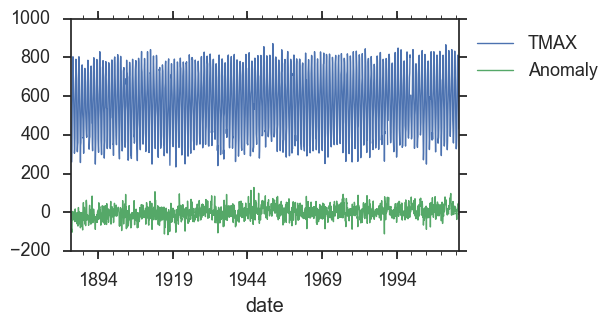

In [87]:
def _anom(x):
    """ De-mean a set of data. """
    return x - x.mean()

# Deseasonalize by removing monhtly means
bluehill_anoms = (
    bluehill_df
     # Split on the "month" of each datestamp in the index
     .groupby(lambda x: x.month)
     .apply(_anom)
)

figsize = (5., 3.)
bluehill_df.tmax.plot(figsize=figsize, lw=1., label="TMAX")
bluehill_anoms.tmax.plot(lw=1, label="Anomaly")
plt.legend(bbox_to_anchor=(1.4, 1.))

### Stations with Largest Diurnal T Difference

In [88]:
tdata = (
    ushcn_data.reset_index('COOP_ID')
    .assign(
        diurnal=lambda x: x['tmax'] - x['tmin'],
        month=lambda x: x.index.month
    )
)

# Compute the max diurnal difference for each month, for each station
diffs = tdata['diurnal'].groupby([tdata['COOP_ID'], tdata['month']]).max()
diffs.head()

COOP_ID  month
11084    1        313.0
         2        333.0
         3        346.0
         4        362.0
         5        371.0
Name: diurnal, dtype: float64

In [135]:
top_100 = (
    diffs
    # Compute the top 100 largest diurnal differences
    .reset_index().sort_values('diurnal').head(100)
    # Merge the station data on to this subset
    .pipe(pd.merge, stations.reset_index(), on='COOP_ID')
    # Group by state and month
    .groupby(['STATE', 'month']).count()
    ['COOP_ID']
)
top_100 = pd.DataFrame({'count': top_100})
top_100.head()

count
STATE month       
CA    2          1
      3          1
      4          1
      5          2
      6          2

#### Top 100 - Month Frequency

In [142]:
month_map = { i: val for i, val in 
              enumerate(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])}

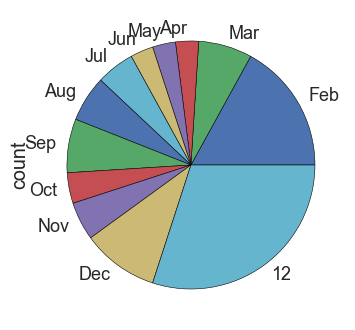

In [144]:
(top_100.reset_index()
 .groupby('month')
 .sum()
 .rename(index=month_map)
 .plot(y='count', kind='pie', figsize=(4, 4), legend=False))

#### Top 100 - State Frequency

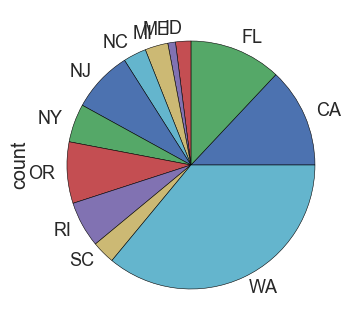

In [148]:
(top_100.reset_index()
 .groupby('STATE')
 .sum()
 .plot(y='count', kind='pie', figsize=(4, 4), legend=False))

### Flexible Plotting

Pandas directly wraps matplotlib for quick access, and matplotlib has functionality to read data structures like DataFrames. 

In [149]:
def get_axs(nrows=1, ncols=1, size=4., aspect=16./10.):
    nrows, ncols = 1, 2
    size, aspect = 4., 16./10.
    width, height = size*ncols*aspect, size*nrows

    fig, axs = plt.subplots(nrows, ncols, figsize=(width, height))
    return axs

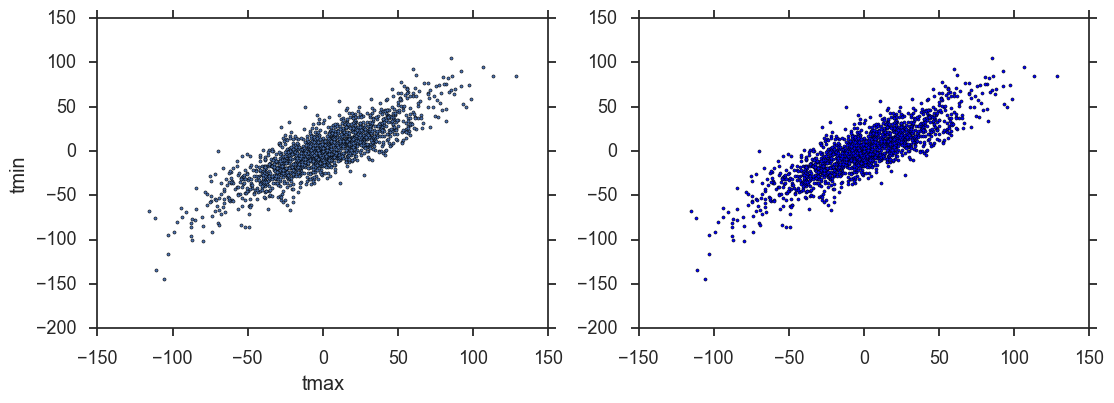

In [150]:
ax1, ax2 = get_axs(ncols=1)
style = dict(marker='.')

# Plot using pandas
bluehill_anoms.plot(x='tmax', y='tmin', kind='scatter', ax=ax1, **style)

# Plot using matplotlib
ax2.scatter('tmax', 'tmin', data=bluehill_anoms, **style)

# Conclusions

### Pandas...

1. ... is a powerful tool for manipulating your labeled and tabular data
2. ... provides built-in features that enable you to more easily and efficiently explore your data
3. ... is easy to pick up and use in your analysis workflow

*Enjoy your analysis*... **use pandas!**

# Additional Information

- [Pandas Documentation](http://pandas.pydata.org/)
- Tom Augspurger's "[Modern Pandas](https://tomaugspurger.github.io/modern-1.html)" Series
    - [Modern Pandas](https://tomaugspurger.github.io/modern-1.html)
    - [Method Chaining](https://tomaugspurger.github.io/method-chaining.html)
    - [Indexes](https://tomaugspurger.github.io/modern-3-indexes.html)
    - [Performance](https://tomaugspurger.github.io/modern-4-performance.html)
    - [Tidy Data](https://tomaugspurger.github.io/modern-5-tidy.html)
    - [Visualization](https://tomaugspurger.github.io/modern-6-visualization.html)
    - [Time Series](https://tomaugspurger.github.io/modern-7-timeseries.html)
 - [Wes McKinney's "Python for Data Analysis"](http://shop.oreilly.com/product/0636920023784.do) - a fantastic (although slightly outdated in some places) overview of Pandas and how to use it for complex data analysis.